# MNIST Classification Demo

## Setting up the Environment

In [112]:
import torch
import torchvision
import matplotlib.pyplot as plt

## Define the Hyperparameters

In [113]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)

## Preparing the Dataset

In [114]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)

In [115]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 1, 28, 28])

## Show dataset demo

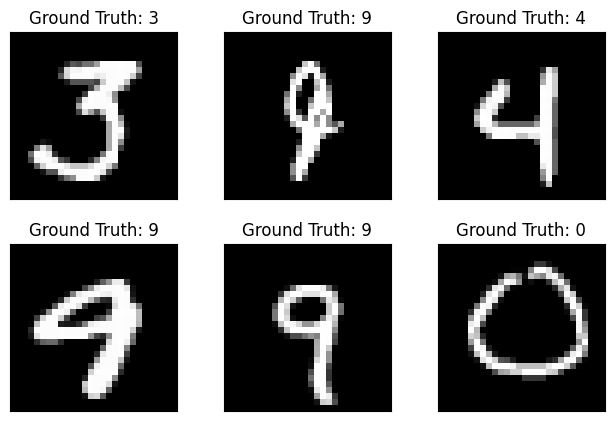

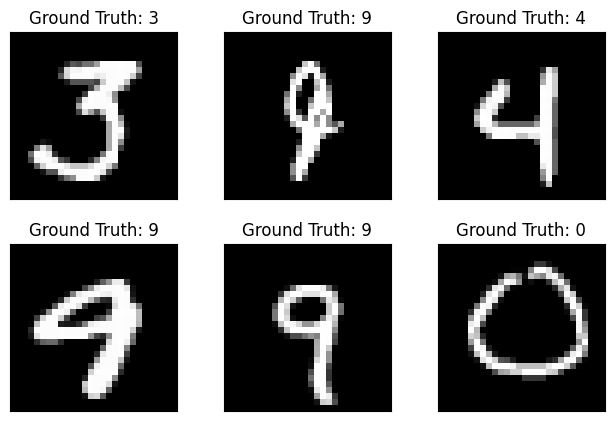

In [116]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

## Building the Network

In [117]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [118]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1      = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2      = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1        = nn.Linear(320, 50)
        self.fc2        = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [119]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## Training the Model

In [120]:
train_losses  = []
train_counter = []
test_losses   = []
test_counter  = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [121]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [122]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [123]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

## Evaluating the Model's Performance

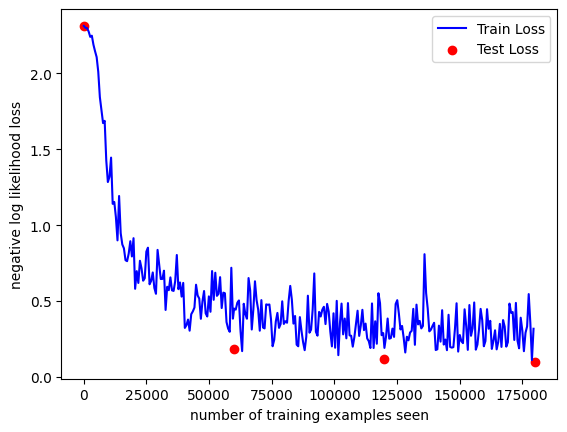

In [124]:
fig1 = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [125]:
with torch.no_grad():
    output = network(example_data)

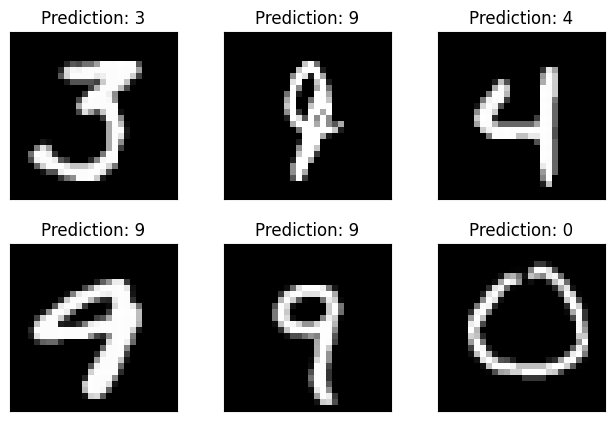

In [126]:
fig2 = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

## Continued Training from Checkpoints

In [127]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [128]:
for i in range(n_epochs + 1, 9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.196789
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.367399
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.346102
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.416675
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.505599
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.144359
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.279822
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.326189
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.155756
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.210443
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.163596
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.149523
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.216669
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.396690
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.436237
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.155607
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.138092
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.487422
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.145265
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.212427
Train Epoch: 4 [12800/60000 (

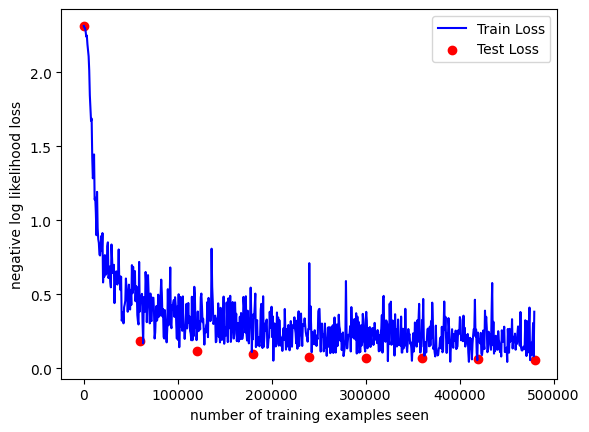

In [129]:
fig3 = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()